In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

from pathlib import Path

import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
import splitfolders
import os

Configurar TensorFlow para usar la GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], False)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

Elimina y recrea directorio split_imagenes, divide imágenes en carpetas de entrenamiento y validación

In [3]:
transformada = "cmor"

#Ruta al directoria split_imagenes
ruta_imagenes = Path(f"../../../imagenes/{transformada}")
ruta_split_imagenes = Path(f"../../../split_imagenes/{transformada}")

#Si el directorio ya existe, eliminarlo junto con su contendio
if ruta_split_imagenes.exists():
    shutil.rmtree(ruta_split_imagenes)

#Crear el split de las imágenes de la transformada
splitfolders.ratio(input=ruta_imagenes, output=ruta_split_imagenes, ratio=(.8,.2))

Copying files: 4000 files [00:07, 504.08 files/s]


Se definen algunos parámetros

In [4]:
img_width, img_height = 250, 250
input_shape = (img_width, img_height, 3)
epochs = 100
batch_size = 32

Se crean los generadores de datos de imágenes

In [5]:
# Configurar el generador de datos de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes de entrenamiento
generador_entrenamiento = train_datagen.flow_from_directory(
    ruta_split_imagenes/"train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Cargar imágenes de validación
generador_validacion = valid_datagen.flow_from_directory(
    ruta_split_imagenes/"val",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
tamanio_ventana = (2,2)

# Definir el modelo CNN
clasificador = Sequential()

clasificador.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
clasificador.add(MaxPooling2D(pool_size=tamanio_ventana))
clasificador.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
clasificador.add(MaxPooling2D(pool_size=tamanio_ventana))
clasificador.add(Conv2D(8, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
clasificador.add(MaxPooling2D(pool_size=tamanio_ventana))


# Capa de aplanamiento
clasificador.add(Flatten())

# Se agregan las capas densas
clasificador.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
clasificador.add(Dropout(rate=0.5))

# Capa de salida
clasificador.add(Dense(units=1, activation='sigmoid'))

In [7]:
# Compilar el modelo
clasificador.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

# Entrenar el modelo
history = clasificador.fit(
    generador_entrenamiento,
    steps_per_epoch=generador_entrenamiento.samples // batch_size,
    epochs=epochs,
    validation_data=generador_validacion,
    validation_steps=generador_validacion.samples // batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.6403
Epoch 1: val_accuracy improved from -inf to 0.63125, saving model to modelo_generado\mejor_modelo.keras
100/100 [==============================] - 85s 832ms/step - loss: 0.8396 - accuracy: 0.6403 - val_loss: 0.7319 - val_accuracy: 0.6313
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.7069
Epoch 2: val_accuracy improved from 0.63125 to 0.69000, saving model to modelo_generado\mejor_modelo.keras
100/100 [==============================] - 9s 92ms/step - loss: 0.6629 - accuracy: 0.7069 - val_loss: 0.6590 - val_accuracy: 0.6900
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7513
Epoch 3: val_accuracy improved from 0.69000 to 0.73000, saving model to modelo_generado\mejor_modelo.keras
100/100 [==============================] - 9s 92ms/step - loss: 0.5966 - accuracy: 0.7513 - val_loss: 0.6121 - val_accuracy: 

Resumen del modelo

In [9]:
clasificador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 8)        0

Se crean los directorios que almacenarán los resultados de las repeticiones

In [10]:
if not os.path.exists("repeticiones_experimento"):
    os.mkdir("repeticiones_experimento")
    os.mkdir("repeticiones_experimento/imagenes_curvas_roc_auc")
    os.mkdir("repeticiones_experimento/imagenes_entrenamientos/")
    os.mkdir("repeticiones_experimento/imagenes_matriz_confusion/")

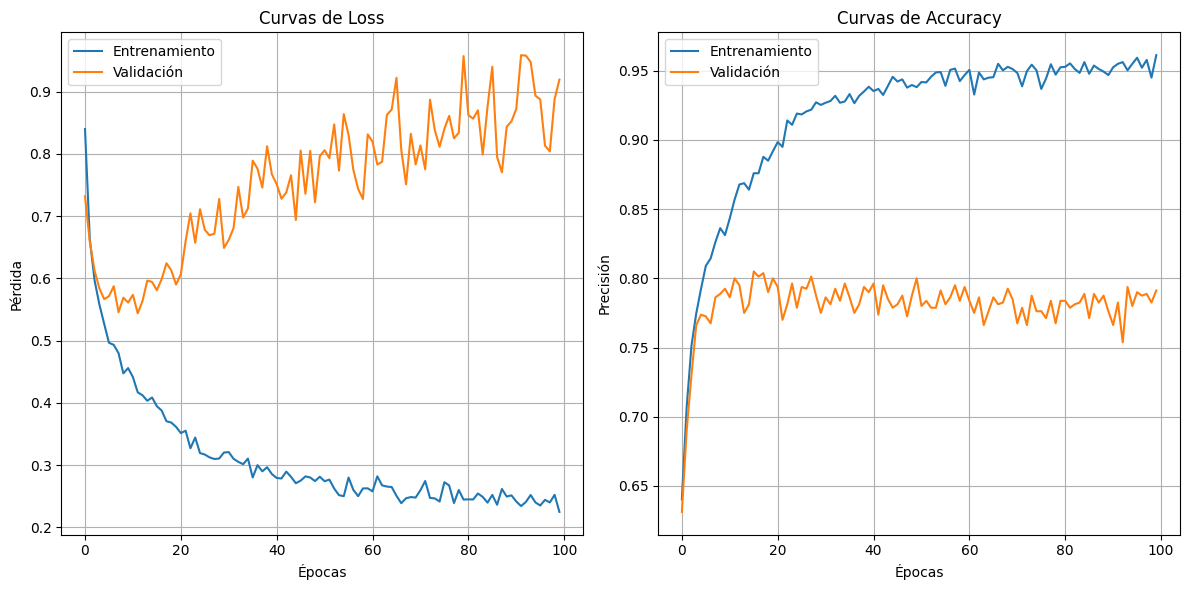

In [11]:
# Graficar las curvas de pérdida y precisión durante el entrenamiento y la validación
plt.figure(figsize=(12, 6))

# Curvas de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curvas de Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curvas de Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

plt.tight_layout()

# Obteniendo el nombre de la imagen para la gráfica de entrenamiento
cant_img_train = len(os.listdir(path="repeticiones_experimento/imagenes_entrenamientos"))
name_img_train = f"imagen_entrenamiento_{cant_img_train+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_entrenamientos/{name_img_train}", dpi=600, bbox_inches='tight')

plt.show()

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [12]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
generador_validacion.reset()
resul_eva = mejor_modelo.evaluate(generador_validacion, verbose=False)

# Obtener los resultados de pérdida y accuracy
perdida = resul_eva[0]
accuracy = resul_eva[1]

print("Loss: {:.2f}".format(perdida))
print("Accuracy: {:.2%}".format(accuracy))

#Crear un Dataframe con los nuevos resultados
new_data = pd.DataFrame({"Loss":[perdida], "Accuracy":[accuracy]})

#Especificar el nombre del archivo Excel
file_name = "resultados_iteraciones/resultados.xlsx"

#Verificar si el archivo ya existe
if os.path.exists(file_name):
    #Si el archivo existe, cargar los datos existentes
    existing_data = pd.read_excel(file_name, sheet_name="Resultados")
    #Concatenar los datos existentes con los nuevos datos
    df = pd.concat([existing_data, new_data], ignore_index=True)
else:
    #Si el archivo no existe, usar solo los nuevos datos
    df = new_data

#Guardar el Dataframe en el archivo Excel
df.to_excel(file_name, sheet_name="Resultados", index=False)

Loss: 0.58
Accuracy: 80.50%


Cálculo de diferentes métricas


Matriz de Confusión:


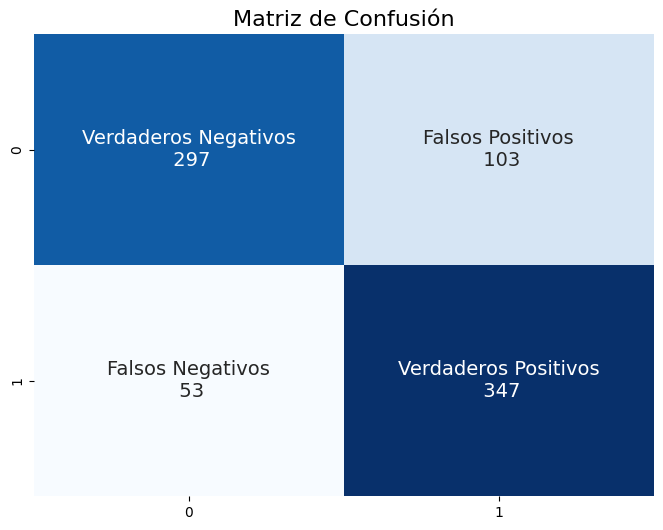

Accuracy:	80.50%
Sensitivity:	86.75%
Specificity:	74.25%
Precision:	77.11%
F1-score:	81.65%


In [13]:
# Obtener las predicciones del modelo
y_pred_prob = mejor_modelo.predict(generador_validacion, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.5).astype(int)

# Obtener las etiquetas verdaderas
y_test = generador_validacion.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)

# Obteniendo el nombre de la imagen para la matriz de confusión
cant_img_matrix = len(os.listdir(path="repeticiones_experimento/imagenes_matriz_confusion"))
name_img_matrix = f"matriz_confusion_{cant_img_matrix+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_matriz_confusion/{name_img_matrix}", dpi=600, bbox_inches='tight')

plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))

Curva roc y auc

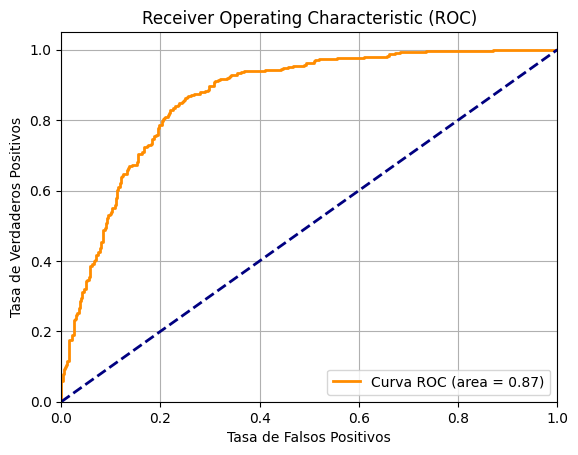

Área Bajo la Curva (AUC): 0.87


In [14]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()

# Obteniendo el nombre de la imagen para la curva ROC-AUC
cant_img_roc_auc = len(os.listdir(path="repeticiones_experimento/imagenes_curvas_roc_auc"))
name_img_roc_auc = f"roc_auc{cant_img_roc_auc+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_curvas_roc_auc/{name_img_roc_auc}", dpi=600, bbox_inches='tight')

plt.show()

# Imprimir el AUC
print(f"Área Bajo la Curva (AUC): {roc_auc:.2f}")

Se registran las métricas en cada iteración del experimento.

In [15]:
# Se crea un Dataframe con los nuevos resultados
new_data = pd.DataFrame({
    "Accuracy"      : [accuracy],
    "Sensitivity"   : [sensitivity],
    "Specificity"   : [specificity],
    "Precision"     : [precision],
    "F1"            : [f1],
    "Roc-Auc"       : [roc_auc]
})

# Especificar el nombre del archivo Excel
file_name = "repeticiones_experimento/metricas.xlsx"

#Verificar si el archivo ya existe
if os.path.exists(file_name):
    #Si el archivo existe, cargar los datos existentes
    existing_data = pd.read_excel(file_name, sheet_name="Métricas")
    #Concatenar los datos existentes con los nuevos datos
    df_metricas = pd.concat([existing_data, new_data], ignore_index=True)
else:
    #Si el archivo no existe, usar solo los nuevos datos
    df_metricas = new_data

#Guardar el Dataframe en el archivo Excel
df_metricas.to_excel(file_name, sheet_name="Métricas", index=False)